# syntax same as numpy

In [24]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax import random
from jax import device_put
from jax import jit, grad, vmap

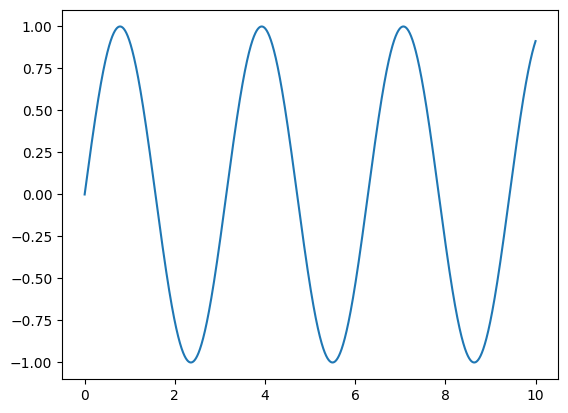

In [7]:
x_np = jnp.linspace(0,10,10000)
y_np = 2*jnp.sin(x_np)*jnp.cos(x_np)
plt.plot(x_np,y_np)

# jax arrays are immutable

In [9]:
size = 10
x = np.arange(size)
print(x)
x[0] = 9
print(x)

[0 1 2 3 4 5 6 7 8 9]
[9 1 2 3 4 5 6 7 8 9]


In [12]:
size = 9
x = jnp.arange(size)
print(x)
x[0] = 9
print(x)

[0 1 2 3 4 5 6 7 8]


TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [13]:
#solution:
y = x.at[0].set(9)
print(y)
print(x)

[9 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]


jax handles random numbers differently

In [19]:
seed = 0
key = random.PRNGKey(seed)

x = random.normal(key,(10,))
print(type(x),x)

<class 'jaxlib.xla_extension.ArrayImpl'> [-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


In [23]:
size = 3000

x_jnp = random.normal(key,(size,size),dtype=jnp.float32)
x_np = np.random.normal(size=(size,size)).astype(np.float32)

%timeit jnp.dot(x_jnp,x_jnp.T).block_until_ready()
%timeit np.dot(x_np,x_np.T)
%timeit jnp.dot(x_np,x_np.T).block_until_ready()

x_np_device = device_put(x_np)
%timeit jnp.dot(x_np_device,x_np_device.T).block_until_ready()

8.42 ms ± 95.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
68.7 ms ± 950 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
32.3 ms ± 773 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
8.46 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# jax tranforamtion funtions:-
jit()

In [25]:
def visualize_fn(fn, l=-10, r=10, n=1000):
    x = np.linspace(l,r,num = n)
    y = fn(x)
    plt.plot(x,y)
    plt.show()

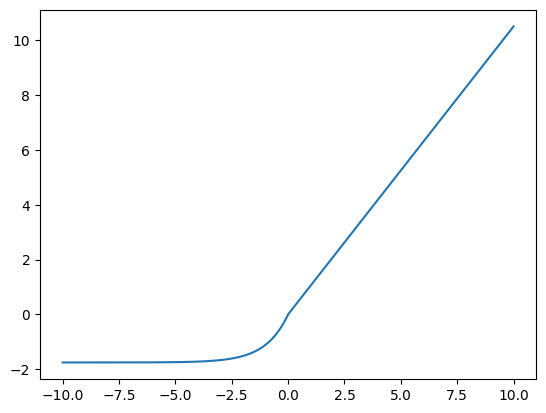

non-jit version:
422 µs ± 4.62 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
jit-version:
83.1 µs ± 1.83 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [28]:
#define a function
def selu(x, alpha = 1.67, lmbda = 1.05):
    return lmbda*jnp.where(x>0,x,alpha*jnp.exp(x)-alpha)

selu_jit = jit(selu)

visualize_fn(selu)

data = random.normal(key,(1000000,))

print('non-jit version:')
%timeit selu(data).block_until_ready()

print('jit-version:')
%timeit selu_jit(data).block_until_ready()

## grad()

In [31]:
def sum_logistic(x):
    return jnp.sum(1.0/(1.0+jnp.exp(-x)))

x = jnp.arange(3.)
loss = sum_logistic

grad_loss = grad(loss)

print(grad_loss(x))

[0.25       0.19661194 0.10499357]


## vmap()
write your functions as if you were dealing with a single datapoint

In [33]:
W = random.normal(key,(150,100)) #weights on NN
batched_x =  random.normal(key,(10,100)) #batch of 10 flattened images

def apply_matrix(x):
    return jnp.dot(W,x)

In [34]:
def naively_batched_apply_matrix(batched_x):
    return jnp.stack([apply_matrix(x) for x in batched_x])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
829 µs ± 28.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [36]:
@jit
def batched_apply_matrix(batched_x):
    return jnp.dot(batched_x,W.T) 
print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
31.5 µs ± 937 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [41]:
@jit
def vmap_batched_apply_matrix(batched_x):
    return vmap(apply_matrix)(batched_x)

print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
29.9 µs ± 2.42 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [46]:
a =jnp.arange(20)
print(a)
def square(x:int)->int:
    return x**2
print(square(a))
map_sq = vmap(square)
print(map_sq(a))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[  0   1   4   9  16  25  36  49  64  81 100 121 144 169 196 225 256 289
 324 361]
[  0   1   4   9  16  25  36  49  64  81 100 121 144 169 196 225 256 289
 324 361]


In [59]:
def sum_vector(x):
    return jnp.sum(x)

a = jnp.arange(6).reshape((2,3))
print(sum_vector(a))
row_sum = vmap(sum_vector, in_axes=0)
print(row_sum(a))

col_sum = vmap(sum_vector, in_axes=1)
print(col_sum(a))

15
[ 3 12]
[3 5 7]


In [67]:
def softmax(x):
    return jnp.exp(x) / jnp.sum(jnp.exp(x))

a = jnp.arange(16).reshape((4,4))

normalized_transformation = vmap(softmax)
normalized_transformation(a)

Array([[0.0320586 , 0.08714432, 0.23688282, 0.6439143 ],
       [0.0320586 , 0.08714431, 0.23688279, 0.6439142 ],
       [0.0320586 , 0.08714432, 0.23688282, 0.6439143 ],
       [0.0320586 , 0.08714432, 0.23688282, 0.6439142 ]], dtype=float32)